# Pattern Recognition
## Computer Homework 1
## Ehsan Kouchaki
### Nov. 28, 2021
####

### Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

### Functions

In [2]:
# Gaussian probability density
def gaussian_probability(x, mean, cov):
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    x_mu = x - mean
    return 1/(2*np.pi*np.sqrt(det_cov))*np.exp(-0.5 * x_mu@inv_cov@x_mu)
    
# discriminant function based on MBE classifier
def discriminant(x, mean, cov, Pw):
    x_mu = x - mean
    sigma_inv = np.linalg.inv(cov)
    ci = - np.log(2*np.pi) -0.5*np.log(np.linalg.det(cov))
    return ci - 0.5*x_mu@sigma_inv@x_mu + np.log(Pw)

# Mahalanibis distance
def mahalanobis(x, mean, cov):
    x_mu = x - mean
    sigma_inv = np.linalg.inv(cov)
    return np.sqrt(x_mu@sigma_inv@x_mu)

# Euclidean distance
def euclidean(x, mean):
    x_mu = x - mean
    return np.sqrt(x_mu@x_mu)

## Excercise1: Problem 2.5 of text book

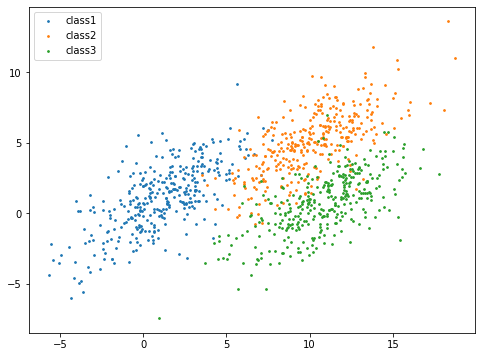

In [3]:
mu1 = [1, 1]; mu2 = [10, 5]; mu3 = [11, 1]
cov = [[7, 4], [4, 5]]

sample1 = []; sample2 = []; sample3 = []

class_selector = np.random.randint(3, size=1000, dtype=int)
for i in range(len(class_selector)):
    if class_selector[i] == 0:
        mu = mu1
        sample1.append(np.random.multivariate_normal(mu, cov, 1))
    elif class_selector[i] == 1:
        mu = mu2
        sample2.append(np.random.multivariate_normal(mu, cov, 1))
    elif class_selector[i] == 2:
        mu = mu3
        sample3.append(np.random.multivariate_normal(mu, cov, 1))

sample1 = np.reshape(sample1, (len(sample1), 2))
sample2 = np.reshape(sample2, (len(sample2), 2))
sample3 = np.reshape(sample3, (len(sample3), 2))

plt.figure(figsize = (8,6))
plt.scatter(sample1[:, 0], sample1[:, 1], s = 3)
plt.scatter(sample2[:, 0], sample2[:, 1], s = 3)
plt.scatter(sample3[:, 0], sample3[:, 1], s = 3)
plt.legend(["class1", "class2", "class3"])

In [4]:
sample1 = np.concatenate((sample1, np.ones((len(sample1), 1))), 1)
sample2 = np.concatenate((sample2, 2*np.ones((len(sample2), 1))), 1)
sample3 = np.concatenate((sample3, 3*np.ones((len(sample3), 1))), 1)
all_samples = np.concatenate((sample1, sample2, sample3))

Pw1 = len(sample1) / len(all_samples)
Pw2 = len(sample2) / len(all_samples)
Pw3 = len(sample3) / len(all_samples)

BME_error = 0
Ecl_error = 0
Mah_error = 0
predictions = []

for i in range(len(all_samples)):
    xi = all_samples[i][0:2]
    xi_realclass = all_samples[i][2]
    
    # posterior probabilities
    Pw1_xi = gaussian_probability(xi, mu1, cov) * Pw1
    Pw2_xi = gaussian_probability(xi, mu2, cov) * Pw2
    Pw3_xi = gaussian_probability(xi, mu3, cov) * Pw3
    
    # Euclidean distances
    Ed_xi_1 = euclidean(xi, mu1)
    Ed_xi_2 = euclidean(xi, mu2)
    Ed_xi_3 = euclidean(xi, mu3)
    
    # Mahalanobis distances
    Md_xi_1 = mahalanobis(xi, mu1, cov)
    Md_xi_2 = mahalanobis(xi, mu2, cov)
    Md_xi_3 = mahalanobis(xi, mu3, cov)
    
    MBE_prd_class = np.argmax([Pw1_xi, Pw2_xi, Pw3_xi]) + 1
    Ecl_prd_class = np.argmin([Ed_xi_1, Ed_xi_2, Ed_xi_3]) + 1
    Mah_prd_class = np.argmin([Md_xi_1, Md_xi_2, Md_xi_3]) + 1
    
    if MBE_prd_class != xi_realclass: BME_error +=1
    if Ecl_prd_class != xi_realclass: Ecl_error +=1
    if Mah_prd_class != xi_realclass: Mah_error +=1
    
    predictions.append([MBE_prd_class, Ecl_prd_class, Mah_prd_class])
    
BME_error_rate = BME_error / len(all_samples)    
Ecl_error_rate = Ecl_error / len(all_samples)    
Mah_error_rate = Mah_error / len(all_samples)    

print('The MBE error rate is: ', BME_error_rate)
print('The Ecl error rate is: ', Ecl_error_rate)
print('The Mah error rate is: ', Mah_error_rate, '\n')

predictions = np.reshape(predictions, (len(all_samples),3))
print('The prediction result of three classifiers are:\n')
pd.DataFrame(predictions, columns=['MBE', 'Ecl', 'Mah'])


The MBE error rate is:  0.07
The Ecl error rate is:  0.117
The Mah error rate is:  0.07 

The prediction result of three classifiers are:



,MBE,Ecl,Mah
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1
...,...,...,...
995,3,3,3
996,3,3,3
997,3,3,3
998,3,3,3


## Excercise 2 - Part (a) Iris data

In [5]:
df = pd.read_fwf('Iris-Data_dat.txt', header=None)
data_iris = df.to_numpy()

Pw1_iris = 1/3; Pw2_iris = 1/3; Pw3_iris = 1/3

confusion_iris = np.zeros((3, 3))
for i in range(150):
    train_data_iris = np.delete(data_iris, (i), axis=0)
    if (i < 50):
        train_data_iris_c1 = train_data_iris[0:49]
        train_data_iris_c2 = train_data_iris[49:99]
        train_data_iris_c3 = train_data_iris[99:149]
    elif (i >= 50 and i < 100):
        train_data_iris_c1 = train_data_iris[0:50]
        train_data_iris_c2 = train_data_iris[50:99]
        train_data_iris_c3 = train_data_iris[99:149]
    else:
        train_data_iris_c1 = train_data_iris[0:50]
        train_data_iris_c2 = train_data_iris[50:100]
        train_data_iris_c3 = train_data_iris[100:149]
        
    mu1_iris = np.mean(train_data_iris_c1[:,1:5], 0)
    mu2_iris = np.mean(train_data_iris_c2[:,1:5], 0)
    mu3_iris = np.mean(train_data_iris_c3[:,1:5], 0)

    cov1_iris = np.cov(train_data_iris_c1[:,1:5].T)
    cov2_iris = np.cov(train_data_iris_c2[:,1:5].T)
    cov3_iris = np.cov(train_data_iris_c3[:,1:5].T)
    
    if (i == 0):
        print('The stimated parameters of the first classifier are as follows:\n')
        print('mean vector of the first class is:\n', mu1_iris, '\n')
        print('covariance matrix of the first class is:\n', cov1_iris, '\n')
        print('mean vector of the second class is:\n', mu2_iris, '\n')
        print('covariance matrix of the second class is:\n', cov2_iris, '\n')
        print('mean vector of the third class is:\n', mu3_iris, '\n')
        print('covariance matrix of the third class is:\n', cov3_iris, '\n')
    
    g1 = discriminant(data_iris[i][1:5], mu1_iris, cov1_iris, Pw1_iris)
    g2 = discriminant(data_iris[i][1:5], mu2_iris, cov2_iris, Pw2_iris)
    g3 = discriminant(data_iris[i][1:5], mu3_iris, cov3_iris, Pw3_iris)    
    
    if (np.argmax([g1, g2, g3]) != data_iris[i][0] - 1):
        confusion_iris[data_iris[i][0] - 1][np.argmax([g1, g2, g3])] += 1
        print('Sample no.{} from class {} incorrectly classified to class {} with g{}={} and g{}={}'
              .format(i + 1,
                      data_iris[i][0],
                      np.argmax([g1, g2, g3])+1,
                      data_iris[i][0],
                      "%.3f" % [g1, g2, g3][data_iris[i][0]-1],
                      np.argmax([g1, g2, g3])+1,
                      "%.3f" % np.max([g1, g2, g3])))
        
for i in range(3):
    confusion_iris[i][i] = 50 - np.sum(confusion_iris[i])
confusion_matrix_iris = pd.DataFrame(confusion_iris, index=['c1(actual)', 'c2(actual)', 'c3(actual)'],
                                columns=['c1(predicted)', 'c2(predicted)', 'c3(predicted)'])
print('\n confusion matrix is:')
confusion_matrix_iris

The stimated parameters of the first classifier are as follows:

mean vector of the first class is:
 [50.04081633 34.26530612 14.63265306  2.46938776] 

covariance matrix of the first class is:
 [[12.66496599 10.11394558  1.68197279  1.06377551]
 [10.11394558 14.65731293  1.20365646  0.95620748]
 [ 1.68197279  1.20365646  3.07057823  0.61352041]
 [ 1.06377551  0.95620748  0.61352041  1.1292517 ]] 

mean vector of the second class is:
 [59.36 27.7  42.6  13.26] 

covariance matrix of the second class is:
 [[26.64326531  8.51836735 18.28979592  5.57795918]
 [ 8.51836735  9.84693878  8.26530612  4.12040816]
 [18.28979592  8.26530612 22.08163265  7.31020408]
 [ 5.57795918  4.12040816  7.31020408  3.91061224]] 

mean vector of the third class is:
 [65.88 29.74 55.52 20.26] 

covariance matrix of the third class is:
 [[40.43428571  9.37632653 30.32897959  4.90938776]
 [ 9.37632653 10.40040816  7.13795918  4.76285714]
 [30.32897959  7.13795918 30.45877551  4.88244898]
 [ 4.90938776  4.7628571

,c1(predicted),c2(predicted),c3(predicted)
c1(actual),50.0,0.0,0.0
c2(actual),0.0,47.0,3.0
c3(actual),0.0,1.0,49.0


In [7]:
print('The error rate of class 1 is: ', (confusion_iris[0][1] + confusion_iris[0][2])/50)
print('The error rate of class 2 is: ', (confusion_iris[1][0] + confusion_iris[1][2])/50)
print('The error rate of class 3 is: ', (confusion_iris[2][0] + confusion_iris[2][1])/50)

The error rate of class 1 is:  0.0
The error rate of class 2 is:  0.06
The error rate of class 3 is:  0.02


## Excercise 2 - Part (b) Liquid data

In [3]:
df = pd.read_fwf('Liquid-Data_dat.txt', header=None)
data_liquid = df.to_numpy()

Pw1_liquid = 1/3; Pw2_liquid = 1/3; Pw3_liquid = 1/3

confusion_liquid = np.zeros((3, 3))
for i in range(178):
    train_data_liquid = np.delete(data_liquid, (i), axis=0)
    if (i < 59):
        train_data_liquid_c1 = train_data_liquid[0:58]
        train_data_liquid_c2 = train_data_liquid[58:129]
        train_data_liquid_c3 = train_data_liquid[129:178]
    elif (i >= 59 and i < 130):
        train_data_liquid_c1 = train_data_liquid[0:59]
        train_data_liquid_c2 = train_data_liquid[59:129]
        train_data_liquid_c3 = train_data_liquid[129:178]
    else:
        train_data_liquid_c1 = train_data_liquid[0:59]
        train_data_liquid_c2 = train_data_liquid[59:130]
        train_data_liquid_c3 = train_data_liquid[130:178]
        
    mu1_liquid = np.mean(train_data_liquid_c1[:,1:7], 0)
    mu2_liquid = np.mean(train_data_liquid_c2[:,1:7], 0)
    mu3_liquid = np.mean(train_data_liquid_c3[:,1:7], 0)

    cov1_liquid = np.cov(train_data_liquid_c1[:,1:7].T)
    cov2_liquid = np.cov(train_data_liquid_c2[:,1:7].T)
    cov3_liquid = np.cov(train_data_liquid_c3[:,1:7].T)
    
    if (i == 0):
        print('The stimated parameters of the first classifier are as follows:\n')
        print('mean vector of the first class is:\n', mu1_liquid, '\n')
        print('covariance matrix of the first class is:\n', cov1_liquid, '\n')
        print('mean vector of the second class is:\n', mu2_liquid, '\n')
        print('covariance matrix of the second class is:\n', cov2_liquid, '\n')
        print('mean vector of the third class is:\n', mu3_liquid, '\n')
        print('covariance matrix of the third class is:\n', cov3_liquid, '\n')
    
    g1 = discriminant(data_liquid[i][1:7], mu1_liquid, cov1_liquid, Pw1_liquid)
    g2 = discriminant(data_liquid[i][1:7], mu2_liquid, cov2_liquid, Pw2_liquid)
    g3 = discriminant(data_liquid[i][1:7], mu3_liquid, cov3_liquid, Pw3_liquid)
    
    if (np.argmax([g1, g2, g3]) != data_liquid[i][0] - 1):
        confusion_liquid[data_liquid[i][0] - 1][np.argmax([g1, g2, g3])] += 1
        print('Sample no.{} from class {} incorrectly classified to class {} with g{}={} and g{}={}'
              .format(i + 1,
                      data_liquid[i][0],
                      np.argmax([g1, g2, g3])+1,
                      data_liquid[i][0],
                      "%.3f" % [g1, g2, g3][data_liquid[i][0]-1],
                      np.argmax([g1, g2, g3])+1,
                      "%.3f" % np.max([g1, g2, g3])))
        
confusion_liquid[0][0] = 59 - np.sum(confusion_liquid[0])
confusion_liquid[1][1] = 80 - np.sum(confusion_liquid[1])
confusion_liquid[2][2] = 47 - np.sum(confusion_liquid[2])
confusion_matrix_liquid = pd.DataFrame(confusion_liquid, index=['c1(actual)', 'c2(actual)', 'c3(actual)'],
                                columns=['c1(predicted)', 'c2(predicted)', 'c3(predicted)'])
print('\n confusion matrix is:')
confusion_matrix_liquid

The stimated parameters of the first classifier are as follows:

mean vector of the first class is:
 [1373.63793103  245.60344828  298.10344828  552.63793103  106.24137931
 1116.5862069 ] 

covariance matrix of the first class is:
 [[ 2.13104204e+03 -1.56514519e+02  7.68792498e+02  2.36828766e+03
   4.57380520e+01  3.80063702e+03]
 [-1.56514519e+02  5.24980339e+02 -6.43793103e+01 -3.55128554e+02
   6.43079250e+01 -1.53500302e+02]
 [ 7.68792498e+02 -6.43793103e+01  1.60665578e+03  3.71338899e+03
   4.00967937e+00  3.41574531e+03]
 [ 2.36828766e+03 -3.55128554e+02  3.71338899e+03  1.56075333e+04
   4.18784029e+01  1.64475844e+04]
 [ 4.57380520e+01  6.43079250e+01  4.00967937e+00  4.18784029e+01
   1.37975802e+02  9.25803388e+02]
 [ 3.80063702e+03 -1.53500302e+02  3.41574531e+03  1.64475844e+04
   9.25803388e+02  4.98864574e+04]] 

mean vector of the second class is:
 [1227.87323944  224.47887324  208.08450704  308.66197183  105.63380282
  519.50704225] 

covariance matrix of the second c

,c1(predicted),c2(predicted),c3(predicted)
c1(actual),59.0,0.0,0.0
c2(actual),1.0,79.0,0.0
c3(actual),0.0,0.0,47.0


In [9]:
print('The error rate of class 1 is: ', (confusion_liquid[0][1] + confusion_liquid[0][2])/59)
print('The error rate of class 2 is: ', (confusion_liquid[1][0] + confusion_liquid[1][2])/80)
print('The error rate of class 3 is: ', (confusion_liquid[2][0] + confusion_liquid[2][1])/47)

The error rate of class 1 is:  0.0
The error rate of class 2 is:  0.0125
The error rate of class 3 is:  0.0


## Excercise 2 - Part (c) Normal data

In [10]:
df_train = pd.read_fwf('Normal-Data-Training_dat.txt', header=None)
df_test = pd.read_fwf('Normal-Data-Testing_dat.txt', header=None)

data_train = df_train.to_numpy()
data_test = df_test.to_numpy()

data_c1 = np.concatenate((data_train[0: 500], data_test[0: 500]))
data_c2 = np.concatenate((data_train[500: 1000], data_test[500: 1000]))

mu1_normal = np.mean(data_train[0: 500][:, 1: 3], 0)
mu2_normal = np.mean(data_train[500: 1000][:, 1: 3], 0)

cov1_normal = np.cov(data_train[0: 500][:, 1: 3].T)
cov2_normal = np.cov(data_train[500: 1000][:, 1: 3].T)

Pw1_normal = 1/2; Pw2_normal = 1/2

BME_error_c1 = 0
BME_error_c2 = 0
predictions_normal = []
miss_classified = []

for i in range(1000):
    xi = data_test[i][1:3]
    xi_realclass = data_test[i][0]
    
    # posterior probabilities
    Pw1_xi_normal = gaussian_probability(xi, mu1_normal, cov1_normal) * Pw1_normal
    Pw2_xi_normal = gaussian_probability(xi, mu2_normal, cov2_normal) * Pw2_normal
    
    MBE_prd_class = np.argmax([Pw1_xi_normal, Pw2_xi_normal]) + 1
    if MBE_prd_class != xi_realclass:
        if xi_realclass == 1:
            BME_error_c1 += 1
        elif xi_realclass == 2:
            BME_error_c2 += 1
        miss_classified.append(xi)
    
    predictions_normal.append(MBE_prd_class)
    
BME_error_rate_c1 = BME_error_c1 / 500    
BME_error_rate_c2 = BME_error_c2 / 500
BME_error_overal = (BME_error_c1 + BME_error_c2) / 1000
predictions_normal = np.reshape(predictions_normal, (1000,1))
miss_classified = np.reshape(miss_classified, (len(miss_classified),2))

print('There are ', len(miss_classified), ' number of miss classified samples which are: \n', miss_classified)
print('\n The empirical MBE error rate of class 1 is: ', BME_error_rate_c1)
print('\n The empirical MBE error rate of class 2 is: ', BME_error_rate_c2)
print('\n The overal MBE error rate is: ', BME_error_overal)
print('\nThe prediction result of the BME classifier are:\n')
pd.DataFrame(predictions_normal, columns=['predicted class'])


There are  67  number of miss classified samples which are: 
 [[ 4.70322 -2.10686]
 [ 1.97342 -1.63515]
 [ 3.75584  0.67229]
 [ 3.07022 -1.43223]
 [ 3.04898 -0.47912]
 [ 2.227   -0.47981]
 [ 2.66868  0.03183]
 [ 2.58775  2.14705]
 [ 2.24001  1.94977]
 [ 2.81188 -1.09898]
 [ 2.0355  -1.40751]
 [ 2.89687  1.90231]
 [ 2.52189  0.39754]
 [ 2.57426 -1.18234]
 [ 2.23446 -3.56311]
 [ 3.38323 -1.30199]
 [ 2.70403 -0.43103]
 [ 2.77489 -2.13982]
 [ 3.76837 -1.70591]
 [ 2.12836  0.35701]
 [ 2.48586 -3.40404]
 [ 2.09471  0.90322]
 [ 2.73993 -1.83952]
 [ 2.90996  1.01473]
 [ 3.18676 -0.32529]
 [ 2.3942  -0.32267]
 [ 2.13373 -0.47543]
 [ 2.37128  0.2617 ]
 [ 2.89088  0.69116]
 [ 3.41449  0.67006]
 [ 2.84868  0.12159]
 [ 4.04258  0.81451]
 [ 1.33864 -0.03085]
 [ 0.09376  0.14738]
 [ 1.57324  0.74043]
 [ 1.98224  0.9617 ]
 [ 1.71587  1.56457]
 [ 1.0961  -1.026  ]
 [ 1.81658 -0.71752]
 [ 1.13653  1.85278]
 [ 1.47484 -0.24983]
 [ 1.82945 -1.12938]
 [ 1.97397 -0.43115]
 [ 1.66787  1.5741 ]
 [ 1.84533  1.

,predicted class
0,1
1,1
2,1
3,1
4,1
...,...
995,2
996,2
997,2
998,2


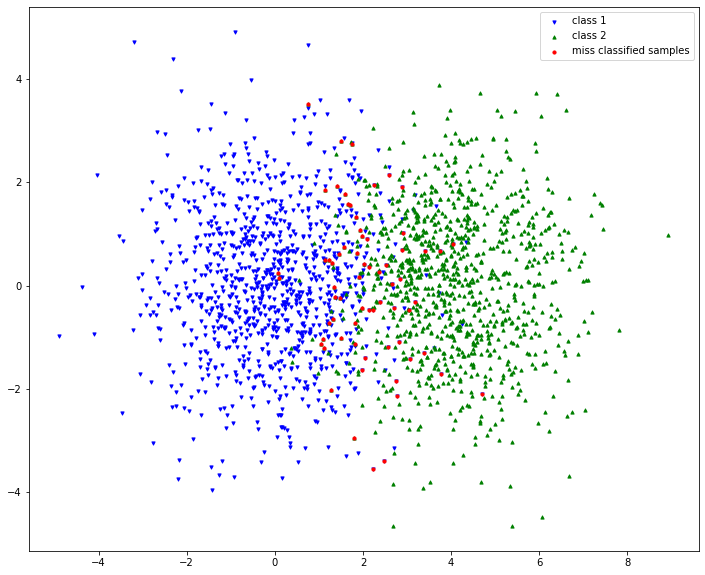

In [11]:
plt.figure(figsize = (12, 10))
plt.scatter(data_c1[:,1], data_c1[:,2], s = 10, c ='blue', marker = 'v')
plt.scatter(data_c2[:,1], data_c2[:,2], s = 10, c ='green', marker = '^')
plt.scatter(miss_classified[:,0], miss_classified[:,1], s = 10 , c = 'red')
plt.legend(['class 1', 'class 2', 'miss classified samples'])

In [12]:
def Px_w1(x1, x2):
    return 1/(4*np.pi) * np.exp(-0.25 * (x1**2 + x2**2))

def Px_w2(x1, x2):
    return 1/(4*np.pi) * np.exp(-0.25 * ((x1 - 4)**2 + x2**2))

I1 = integrate.nquad(Px_w1, [[2, np.inf],[-np.inf, np.inf]])
I2 = integrate.nquad(Px_w2, [[-np.inf, 2],[-np.inf, np.inf]])
Pe = 1/2 * I1[0] + 1/2 * I2[0]
print('The theoretical error rate is: ', '%.4f' % Pe)

The theoretical error rate is:  0.0786
